# Trayendo datos de poloniex y convirtiendolos en dataframe

In [81]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2014-09-10 00:00:00"),
                  end=string2ts("2017-09-01 00:00:00"),
                  period=3600*4)

# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]

per = 0.9
cum_return1 = marketReturn(df[:int(len(df)*per)])
cum_return2 = marketReturn(df[int(len(df)*per):]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()


Retorno final del mercado: 1282.14643932


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2014-09-10 03:00:00,0.00001,0.00001,0.00001,0.00001,0,0.000000,0.00001
2014-09-10 07:00:00,0.00001,0.00001,0.00001,0.00001,2280.78254325,0.022658,0.00001
2014-09-10 11:00:00,0.00001,0.00001,0.00001,0.00001,8005.14238168,0.080851,0.00001
2014-09-10 15:00:00,0.00001,0.00001,0.00001,0.00001,3367.968,0.033643,0.00001
2014-09-10 19:00:00,0.00001,0.00001,0.00001,0.00001,5490,0.054516,0.00001


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

In [82]:
from strategy import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3, diff = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)
"""
plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()
"""

Retorno del mercacdo: 1282.14643932
Retorno de SMA13 VS EMA5: 639.549655514
Retorno de Precio VS SMA20: 67.2173825969
Retorno de Precio VS EMA5: 508.955179219


"\nplt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')\nplt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')\nplt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')\nplt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')\n\nplt.legend(loc='best')\nplt.grid()\n"

## RSI via stockstacks

In [83]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 1.48485030284e+21
5868 653


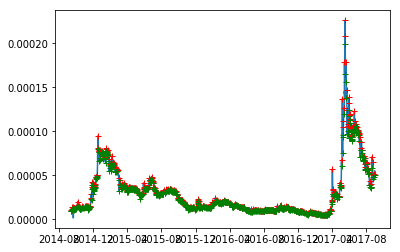

In [84]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["weightedAverage"],"volumen":df["volume"],"rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],"wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],"ideal_w":w4["w"],"diff":diff})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(df)*per)]
test = data[int(len(df)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
print len(train),len(test)

# Creando modelo de regresion logistica utilizando sticklearn

In [85]:
from sklearn.linear_model import LogisticRegression

# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","wr","volumen"]


logreg = LogisticRegression()

logreg.fit(train[features],train["ideal_w"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## probando modelo en otros datos

Retorno del mercacdo: -63.3172413793
Retorno de SMA13 VS EMA5: 30.6005153797
Retorno de Precio VS SMA20: 56.6671566895
Retorno de Precio VS EMA5: 52.206754022
Retorno de ML_strategy: 89.0965133075


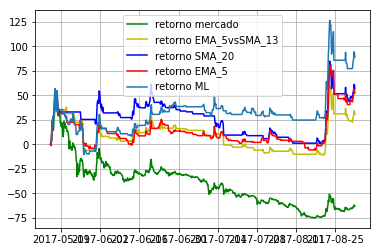

In [86]:
w_pred = logreg.predict(test[features])

w5 = pd.DataFrame(data={"w":w_pred,"price":test["price"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_strategy: %s'%(relativeReturn5*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML')


plt.legend(loc='best')
plt.grid()